# ImageChange Decoder — 2025-10-09

Question: Does the population encode image changes differently from non-changes?

Analysis summary:
- Linear SVM decoders on population activity using ISI averages and time-resolved bins.
- Cross-validated accuracy versus shuffled-label controls evaluated per session.


## Workflow

1. Load aligned trial data via `modules.ReadResults` and `utils.get_neu_trial`.
2. Build a per-trial table mapping stimuli to orientation transitions.
3. Train linear SVM decoders (pooled ISI average and 100 ms time bins).
4. Compare decoder accuracy to label-shuffled controls and visualise example sessions.


In [1]:
import copy
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle


from session_configs import (
    session_config_YH02VT,
    session_config_YH14SC,
    session_config_YH19VT,
    session_config_YH21SC,
)
from modules.ReadResults import read_ops, read_all, read_neural_trials, read_masks
from modules.Alignment import run_get_stim_response
from modules import Trialization
from utils import get_neu_trial, get_frame_idx_from_time, pick_trial


plt.style.use('seaborn-v0_8-darkgrid')
np.set_printoptions(suppress=True)
from modeling.decoding import binary_decoder_cv, binary_timecourse_decoding, multiclass_decoder_cv, multiclass_timecourse_decoding


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
DATA_ROOT = Path('results')
RANDOM_STATE = 0
BIN_WIDTH_MS = 100.0
TIME_WINDOW_MS = (-500.0, 2000.0)

SHUFFLE_BASELINE = True
TRIAL_PARAM = [[2,3,4,5,-2,-3,-4,-5], [0, 1], None, None, [0], [0]]
LABEL_MAP = {-1: 'Exc', 0: 'Inh_VIP', 1: 'Inh_SST'}
BLOCK_LABELS = {0: 'Short', 1: 'Long'}

BASE_CONFIGS = {
    'YH02VT': session_config_YH02VT,
    'YH14SC': session_config_YH14SC,
    'YH19VT': session_config_YH19VT,
    'YH21SC': session_config_YH21SC,
}

TARGET_SESSIONS = {
    # Set to a list of session folder names to restrict, or None to include every available session on disk.
    'YH02VT': None,
    'YH14SC': None,
    'YH19VT': None,
    'YH21SC': None,
}


In [3]:
def filter_session_config(template_cfg, target_sessions=None, data_root=DATA_ROOT):
    cfg = copy.deepcopy(template_cfg)
    available = {}
    targets = None if target_sessions is None else set(target_sessions)
    for session_name, tag in template_cfg['list_session_name'].items():
        if targets is not None and session_name not in targets:
            continue
        session_path = data_root / template_cfg['session_folder'] / session_name
        if session_path.is_dir():
            available[session_name] = tag
    cfg['list_session_name'] = available
    return cfg

def build_selected_configs(base_configs, target_map, data_root=DATA_ROOT):
    selected = []
    for subject, template in base_configs.items():
        targets = target_map.get(subject)
        cfg = filter_session_config(template, targets, data_root=data_root)
        if cfg['list_session_name']:
            selected.append(cfg)
    return selected

def combine_session_config_list(session_config_list):
    combined = copy.deepcopy(session_config_list)
    data_paths = []
    session_name_map = {}
    session_entries = []
    for cfg in combined['list_config']:
        folder = cfg['session_folder']
        for session_name, tag in cfg['list_session_name'].items():
            data_paths.append(str(Path('results') / folder / session_name))
            session_name_map[session_name] = tag
            session_entries.append({
                'subject': folder,
                'session': session_name,
                'tag': tag,
            })
    combined['list_session_data_path'] = data_paths
    combined['list_session_name'] = session_name_map
    return combined, session_entries

def infer_cell_type(labels):
    values, counts = np.unique(labels, return_counts=True)
    cell_type = 'Unknown'
    best_count = -1
    for value, count in zip(values, counts):
        label_name = LABEL_MAP.get(int(value))
        if label_name is not None and count > best_count:
            cell_type = label_name
            best_count = count
    return cell_type


In [ ]:

def compute_trial_metadata(stim_labels):
    stim_labels = np.asarray(stim_labels)
    codes = stim_labels[:, 2].astype(int)
    base_codes = sorted({abs(code) for code in codes if abs(code) >= 2})
    if not base_codes:
        return pd.DataFrame(columns=[
            'trial_index', 'label_code', 'orientation_idx', 'from_orientation_idx',
            'orientation_deg', 'from_orientation_deg', 'theta_change_deg',
            'is_transition', 'block_type', 'stim_start_ms', 'stim_end_ms', 'pair_label'
        ])
    orientation_map = {code: idx for idx, code in enumerate(base_codes, start=1)}
    degrees_reference = [0.0, 45.0, 90.0, 135.0]
    if len(base_codes) == len(degrees_reference):
        orientation_deg_lookup = {
            orientation_map[code]: degrees_reference[i]
            for i, code in enumerate(sorted(base_codes))
        }
    else:
        step = 180.0 / max(len(base_codes), 1)
        orientation_deg_lookup = {
            orientation_map[code]: i * step
            for i, code in enumerate(sorted(base_codes))
        }

    def minimal_theta_diff(a, b):
        if np.isnan(a) or np.isnan(b):
            return np.nan
        diff = abs(a - b) % 180.0
        return diff if diff <= 90.0 else 180.0 - diff

    rows = []
    last_ori_idx = None
    last_ori_key = None
    repeat_count = 0
    for trial_idx, code in enumerate(codes):
        block_type = int(stim_labels[trial_idx, 3])
        if code == -1:
            if last_ori_idx is None:
                continue
            ori_idx = last_ori_idx
            ori_key = last_ori_key
            from_idx = last_ori_idx
            from_key = last_ori_key
            is_transition = False
        else:
            ori_key = abs(code)
            if ori_key not in orientation_map:
                continue
            ori_idx = orientation_map[ori_key]
            from_idx = last_ori_idx if last_ori_idx is not None else ori_idx
            from_key = last_ori_key if last_ori_key is not None else ori_key
            is_transition = bool(code < 0)
        ori_deg = float(orientation_deg_lookup.get(ori_idx, np.nan))
        from_deg = float(orientation_deg_lookup.get(from_idx, ori_deg))
        theta_delta = minimal_theta_diff(ori_deg, from_deg)
        if is_transition:
            repeat_count = 0
            pair_label = f'ori{int(from_idx)}->ori{int(ori_idx)}'
        else:
            repeat_count += 1
            pair_label = f'repeat_ori{int(ori_idx)}'
        rows.append({
            'trial_index': int(trial_idx),
            'label_code': int(code),
            'orientation_idx': int(ori_idx),
            'from_orientation_idx': int(from_idx),
            'orientation_deg': ori_deg,
            'from_orientation_deg': from_deg,
            'theta_change_deg': theta_delta,
            'is_transition': is_transition,
            'block_type': block_type,
            'stim_start_ms': float(stim_labels[trial_idx, 0]),
            'stim_end_ms': float(stim_labels[trial_idx, 1]),
            'pair_label': pair_label,
            'repeat_count': repeat_count,
        })
        last_ori_idx = ori_idx
        last_ori_key = ori_key
    return pd.DataFrame(rows)


def prepare_session_dataset(neu_session, stim_labels, post_isi, neu_time, selected_indices=None):
    trial_meta = compute_trial_metadata(stim_labels)
    if trial_meta.empty:
        return None
    if selected_indices is None:
        selected_indices = np.arange(neu_session.shape[0])
    selected_indices = np.asarray(selected_indices)
    idx_map = {orig: pos for pos, orig in enumerate(selected_indices)}
    trial_meta = trial_meta[trial_meta['trial_index'].isin(idx_map)].copy()
    if trial_meta.empty:
        return None
    trial_meta['selected_index'] = trial_meta['trial_index'].map(idx_map)
    trial_meta = trial_meta.dropna(subset=['selected_index']).sort_values('selected_index').reset_index(drop=True)
    trial_meta['selected_index'] = trial_meta['selected_index'].astype(int)
    post_isi = np.asarray(post_isi).reshape(-1)
    neu_time = np.asarray(neu_time)
    features = []
    valid_idx = []
    trial_indices = []
    stim_durations = trial_meta['stim_end_ms'] - trial_meta['stim_start_ms']
    for row_idx, row in trial_meta.iterrows():
        selected_idx = int(row['selected_index'])
        if selected_idx >= neu_session.shape[0] or selected_idx >= post_isi.size:
            continue
        stim_duration = float(stim_durations.iloc[row_idx])
        isi = float(post_isi[selected_idx])
        if not np.isfinite(isi) or isi <= 0:
            continue
        left = stim_duration
        right = stim_duration + isi
        l_idx, r_idx = get_frame_idx_from_time(neu_time, 0, left, right)
        r_idx = min(r_idx, neu_session.shape[-1])
        if r_idx - l_idx < 2:
            continue
        trace = neu_session[selected_idx, :, l_idx:r_idx]
        if np.all(np.isnan(trace)):
            continue
        feature = np.nanmean(trace, axis=-1)
        if not np.all(np.isfinite(feature)):
            continue
        features.append(feature)
        valid_idx.append(row_idx)
        trial_indices.append(selected_idx)
    if not features:
        return None
    trial_meta_valid = trial_meta.iloc[valid_idx].reset_index(drop=True).copy()
    trial_meta_valid['feature_trial_index'] = trial_indices
    trial_meta_valid['stim_duration_ms'] = trial_meta_valid['stim_end_ms'] - trial_meta_valid['stim_start_ms']
    trial_meta_valid['post_isi_ms'] = [float(post_isi[idx]) for idx in trial_indices]
    X_isi = np.stack(features)
    trial_neu = neu_session[trial_meta_valid['feature_trial_index'].to_numpy(), :, :]
    return {
        'meta': trial_meta_valid,
        'X_isi': X_isi,
        'trial_neu': trial_neu,
        'neu_time': neu_time,
    }



In [5]:
def plot_timecourse(ax, df):
    if df.empty:
        ax.text(0.5, 0.5, 'No timecourse data', ha='center', va='center', transform=ax.transAxes)
        return

    color_iter = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0']))
    handled_labels = set()

    for block_label, block_df in df.groupby('block_label'):
        block_df = block_df.sort_values('time_center_ms')
        color = next(color_iter)
        ax.plot(block_df['time_center_ms'], block_df['accuracy_mean'],
                label=f'{block_label} decoder', color=color)
        if np.any(np.isfinite(block_df['accuracy_sem'])):
            lower = block_df['accuracy_mean'] - block_df['accuracy_sem']
            upper = block_df['accuracy_mean'] + block_df['accuracy_sem']
            ax.fill_between(block_df['time_center_ms'], lower, upper, color=color, alpha=0.2)
        chance_values = block_df['chance_mean']
        chance_sem = block_df['chance_sem']
        if np.isfinite(chance_values).any():
            chance_label = f'{block_label} shuffled'
        else:
            chance_label = None
            ax.plot(block_df['time_center_ms'], chance_values, linestyle='--', color=color, alpha=0.6, label=chance_label)
            if np.any(np.isfinite(chance_sem)):
                lower = chance_values - chance_sem
                upper = chance_values + chance_sem
                ax.fill_between(block_df['time_center_ms'], lower, upper, color=color, alpha=0.15)
        handled_labels.add(f'{block_label} shuffled')

    ax.axhline(0.5, color='grey', linewidth=1, linestyle=':')
    ax.set_ylim(0.3, 1.0)


In [ ]:
selected_configs = build_selected_configs(BASE_CONFIGS, TARGET_SESSIONS, data_root=DATA_ROOT)
if not selected_configs:
    raise RuntimeError('No sessions found. Update TARGET_SESSIONS or ensure data are in the results/ folder.')

session_config_list = {
    'list_config': selected_configs,
    'label_names': {str(k): v for k, v in LABEL_MAP.items()},
    'subject_name': 'ImageChangeDecoder',
    'output_filename': 'ImageChangeDecoder',
}

combined_config, session_entries = combine_session_config_list(session_config_list)
print(f'Selected {len(session_entries)} sessions:')
for entry in session_entries:
    print(f"- {entry['subject']}/{entry['session']} ({entry['tag']})")


Selected 2 sessions:
- YH02VT/VTYH02_PPC_20250228_1451ShortLong (short_long)
- YH19VT/YH19VT_V1_20250421_1451ShortLong (short_long)


In [7]:
list_ops = read_ops(combined_config['list_session_data_path'])
for ops in list_ops:
    Trialization.run(ops)

[list_labels, list_masks, list_neural_trials, list_move_offset] = read_all(combined_config, smooth=False)

alignment = run_get_stim_response('temp_ImageChangeDecoder', list_neural_trials, expected='none')
neu_time = alignment['neu_time']

_, neu_trial_data, _, _ = get_neu_trial(
    alignment,
    list_labels,
    alignment['list_stim_labels'],
    mean_sem=False,
    trial_param = [[2,3,4,5,-2,-3,-4,-5], [0, 1], None, None, [0], [0]], # all except oddball long
    cate=[-1,0,1]  
)
neu_list, stim_seq_list, camera_list, pre_isi_list, post_isi_list = neu_trial_data
print(f'Loaded {len(neu_list)} sessions with aligned neural data.')
selection_indices_list = []
for labels in alignment['list_stim_labels']:
    mask = pick_trial(labels, *TRIAL_PARAM, frac=1)
    selection_indices_list.append(np.where(mask)[0])



Reading subject 1/2


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Reading subject 2/2


100%|██████████| 1/1 [00:00<00:00,  1.31it/s]


Aligning trials for session 1/2


trials: 100%|██████████| 1990/1990 [00:00<00:00, 10217.16it/s]


Aligning trials for session 2/2


trials: 100%|██████████| 1990/1990 [00:00<00:00, 14681.26it/s]


Loaded 2 sessions with aligned neural data.


In [8]:
analysis1_records = []
timecourse_tables = []
session_results = {}

for idx, entry in enumerate(session_entries):
    session_key = f"{entry['subject']}/{entry['session']}"
    neu_session = np.asarray(neu_list[idx])
    stim_labels = np.asarray(alignment['list_stim_labels'][idx])
    post_isi = np.asarray(post_isi_list[idx])
    dataset = prepare_session_dataset(neu_session, stim_labels, post_isi, neu_time, selection_indices_list[idx])
    if dataset is None:
        print(f'Skipping {session_key}: insufficient valid trials after filtering.')
        continue
    y = dataset['meta']['is_transition'].astype(int).to_numpy()
    metrics = binary_decoder_cv(
        dataset['X_isi'],
        y,
        n_splits=5,
        random_state=RANDOM_STATE,
        shuffle_baseline=SHUFFLE_BASELINE,
        downsample=True,
    )
    if metrics is None:
        print(f'Skipping {session_key}: not enough trials per class for cross-validation.')
        continue
    record = {
        'precision_mean': metrics['precision_mean'],
        'precision_sem': metrics['precision_sem'],
        'recall_mean': metrics['recall_mean'],
        'recall_sem': metrics['recall_sem'],
        'f1_mean': metrics['f1_mean'],
        'f1_sem': metrics['f1_sem'],
        'confusion_matrix': metrics['confusion_matrix'].tolist(),
        'subject': entry['subject'],
        'session': entry['session'],
        'session_key': session_key,
        'task_tag': entry['tag'],
        'n_trials': int(dataset['X_isi'].shape[0]),
        'n_neurons': int(dataset['X_isi'].shape[1]),
        'change_fraction': float(y.mean()),
        'accuracy_mean': metrics['mean_acc'],
        'accuracy_sem': metrics['sem_acc'],
        'chance_mean': metrics['mean_chance'],
        'chance_sem': metrics['sem_chance'],
        'n_splits': metrics['n_splits'],
    }
    analysis1_records.append(record)
    session_results[session_key] = {
        'dataset': dataset,
        'metrics_single': metrics,
    }
    timecourse_df = binary_timecourse_decoding(
        dataset['trial_neu'],
        neu_time,
        y,
        block_labels=dataset['meta']['block_type'].to_numpy(),
        bin_width_ms=BIN_WIDTH_MS,
        window=TIME_WINDOW_MS,
        n_splits=5,
        random_state=RANDOM_STATE,
        shuffle_baseline=SHUFFLE_BASELINE,
        downsample=True,
    )
    if not timecourse_df.empty:
        block_codes = timecourse_df['block_type'].astype(int)
        block_labels = block_codes.map(BLOCK_LABELS).fillna(block_codes.astype(str))
        timecourse_df = timecourse_df.assign(
            session=session_key,
            subject=entry['subject'],
            block_label=block_labels,
        )
        timecourse_tables.append(timecourse_df)
    else:
        print(f'No valid timecourse windows for {session_key}.')

analysis1_df = pd.DataFrame(analysis1_records)
analysis1_df = analysis1_df.sort_values(['subject', 'session']).reset_index(drop=True)
analysis1_df


,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,confusion_matrix,subject,session,session_key,task_tag,n_trials,n_neurons,change_fraction,accuracy_mean,accuracy_sem,chance_mean,chance_sem,n_splits
0,0.040243,0.003933,0.6,0.084984,0.075361,0.007535,"[[473, 422], [12, 18]]",YH02VT,VTYH02_PPC_20250228_1451ShortLong,YH02VT/VTYH02_PPC_20250228_1451ShortLong,short_long,1848,95,0.033009,0.530811,0.026114,0.492973,0.017297,5
1,0.045513,0.005729,0.6,0.066667,0.084573,0.010516,"[[518, 382], [12, 18]]",YH19VT,YH19VT_V1_20250421_1451ShortLong,YH19VT/YH19VT_V1_20250421_1451ShortLong,short_long,1859,265,0.033889,0.576344,0.017120,0.494624,0.025896,5


In [9]:
metrics_cols = ['accuracy_mean', 'chance_mean', 'precision_mean', 'recall_mean', 'f1_mean']
metrics_sem_cols = ['accuracy_sem', 'chance_sem', 'precision_sem', 'recall_sem', 'f1_sem']
metrics_df = analysis1_df[['session_key'] + metrics_cols + metrics_sem_cols].copy()
metrics_df


,session_key,accuracy_mean,chance_mean,precision_mean,recall_mean,f1_mean,accuracy_sem,chance_sem,precision_sem,recall_sem,f1_sem
0,YH02VT/VTYH02_PPC_20250228_1451ShortLong,0.530811,0.492973,0.040243,0.6,0.075361,0.026114,0.017297,0.003933,0.084984,0.007535
1,YH19VT/YH19VT_V1_20250421_1451ShortLong,0.576344,0.494624,0.045513,0.6,0.084573,0.017120,0.025896,0.005729,0.066667,0.010516


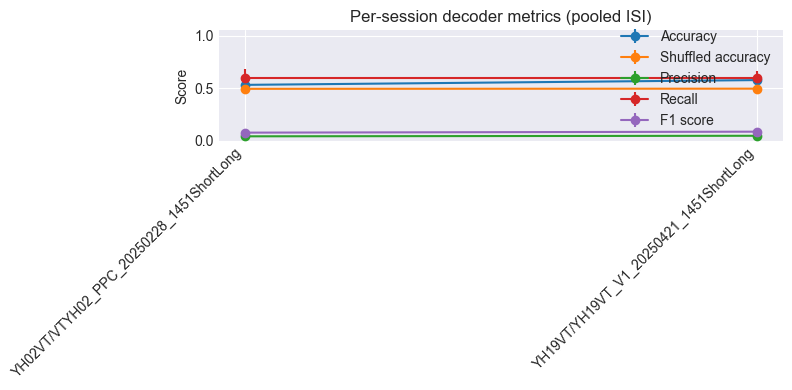

In [10]:
if not metrics_df.empty:
    sessions = metrics_df['session_key']
    x_pos = np.arange(len(sessions))
    label_map = {
        'accuracy_mean': 'Accuracy',
        'chance_mean': 'Shuffled accuracy',
        'precision_mean': 'Precision',
        'recall_mean': 'Recall',
        'f1_mean': 'F1 score',
    }
    fig, ax = plt.subplots(figsize=(8, 4))
    for metric, sem_col in zip(metrics_cols, metrics_sem_cols):
        label = label_map.get(metric, metric.replace('_mean', '').replace('_', ' ').title())
        ax.errorbar(x_pos, metrics_df[metric], yerr=metrics_df[sem_col], fmt='o-', label=label)
    ax.set_ylabel('Score')
    ax.set_ylim(0.0, 1.05)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(sessions, rotation=45, ha='right')
    ax.legend(loc='lower right')
    ax.set_title('Per-session decoder metrics (pooled ISI)')
    plt.tight_layout()
    plt.show()


In [11]:
# Pooled within-session decoder (pool trials across short+long; do NOT pool across sessions)
pooled_rows = []
for session_key, payload in session_results.items():
    ds = payload['dataset']
    X = ds['X_isi']
    y = ds['meta']['is_transition'].astype(int).to_numpy()
    if np.unique(y).size < 2 or (np.bincount(y).min() < 2):
        print(f'Skipping {session_key}: not enough trials per class.')
        continue
    metrics = binary_decoder_cv(
        X, y,
        n_splits=20,
        random_state=RANDOM_STATE,
        shuffle_baseline=SHUFFLE_BASELINE,
        downsample=True,
    )
    pooled_rows.append({
        'session_key': session_key,
        'n_trials': int(X.shape[0]),
        'n_neurons': int(X.shape[1]),
        'change_fraction': float(y.mean()),
        'accuracy_mean': metrics['mean_acc'],
        'accuracy_sem': metrics['sem_acc'],
        'chance_mean': metrics['mean_chance'],
        'chance_sem': metrics['sem_chance'],
        'precision_mean': metrics.get('precision_mean'),
        'precision_sem': metrics.get('precision_sem'),
        'recall_mean': metrics.get('recall_mean'),
        'recall_sem': metrics.get('recall_sem'),
        'f1_mean': metrics.get('f1_mean'),
        'f1_sem': metrics.get('f1_sem'),
        'n_splits': metrics['n_splits'],
        'confusion_matrix': metrics['confusion_matrix'].tolist(),
    })

pooled_per_session = pd.DataFrame(pooled_rows)
pooled_per_session



,session_key,n_trials,n_neurons,change_fraction,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,n_splits,confusion_matrix
0,YH02VT/VTYH02_PPC_20250228_1451ShortLong,1848,95,0.033009,0.508919,0.011595,0.513784,0.011503,0.031202,0.003070,0.475000,0.050255,0.058517,0.005777,20,"[[1826, 1754], [63, 57]]"
1,YH19VT/YH19VT_V1_20250421_1451ShortLong,1859,265,0.033889,0.589516,0.010783,0.518817,0.009308,0.048414,0.003246,0.616667,0.036475,0.089720,0.005949,20,"[[2119, 1481], [46, 74]]"


In [12]:
if 'pooled_summary' in locals():
    pooled_metrics_display = pooled_summary[['n_trials', 'change_fraction', 'accuracy_mean', 'accuracy_sem', 'chance_mean', 'chance_sem', 'precision_mean', 'precision_sem', 'recall_mean', 'recall_sem', 'f1_mean', 'f1_sem']].copy()
    pooled_metrics_display


In [13]:
if 'pooled_summary' in locals():
    cm = np.array(pooled_summary['confusion_matrix'].iloc[0])
    fig, ax = plt.subplots(figsize=(4, 4))
    im = ax.imshow(cm, cmap='Blues')
    ax.set_xticks([0,1])
    ax.set_yticks([0,1])
    ax.set_xticklabels(['Repeat', 'Change'])
    ax.set_yticklabels(['Repeat', 'Change'])
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    for (i, j), val in np.ndenumerate(cm):
        ax.text(j, i, int(val), ha='center', va='center', color='black')
    ax.set_title('Pooled confusion matrix')
    plt.tight_layout()
    plt.show()


In [14]:
timecourse_df_all = pd.concat(timecourse_tables, ignore_index=True) if timecourse_tables else pd.DataFrame()
timecourse_df_all.head()


,block_type,time_start_ms,time_center_ms,time_stop_ms,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,n_splits,session,subject,block_label
0,0,-500.0,-450.0,-400.0,0.548387,0.030031,0.436559,0.041310,0.030040,0.009931,0.400000,0.124722,0.055838,0.018378,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
1,0,-400.0,-350.0,-300.0,0.477419,0.006452,0.518280,0.041142,0.032262,0.010130,0.533333,0.169967,0.060841,0.019121,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
2,0,-300.0,-250.0,-200.0,0.501075,0.022961,0.546237,0.036210,0.029675,0.008484,0.466667,0.133333,0.055768,0.015921,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
3,0,-200.0,-150.0,-100.0,0.423656,0.020850,0.481720,0.056939,0.026201,0.004448,0.466667,0.081650,0.049603,0.008426,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
4,0,-100.0,-50.0,0.0,0.505376,0.023311,0.492473,0.023162,0.046542,0.003683,0.733333,0.066667,0.087478,0.006907,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short


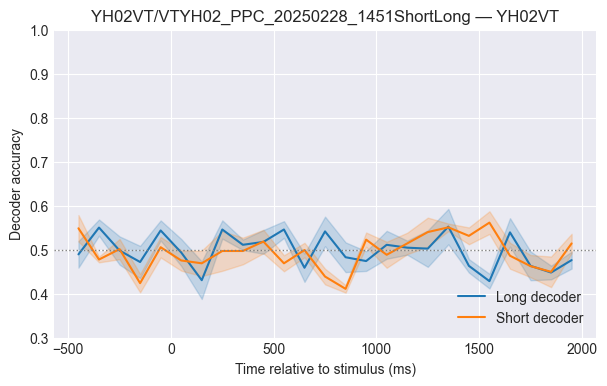

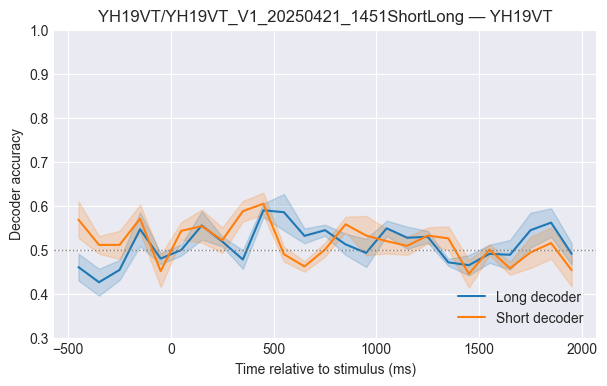

In [15]:
#Version with cell type for later use
# example_sessions = {}
# for record in analysis1_records:
#     ct = record['cell_type']
#     key = record['session_key']
#     if ct not in example_sessions:
#         example_sessions[ct] = key

# for cell_type, session_key in example_sessions.items():
#     if session_key not in session_results:
#         continue
#     df_session = timecourse_df_all[timecourse_df_all['session'] == session_key]
#     if df_session.empty:
#         continue
#     fig, ax = plt.subplots(figsize=(7, 4))
#     plot_timecourse(ax, df_session)
#     ax.set_title(f'{session_key} — {cell_type}')
#     ax.set_xlabel('Time relative to stimulus (ms)')
#     ax.set_ylabel('Decoder accuracy')
#     ax.legend(loc='lower right')
#     plt.show()
example_sessions = {}  # use the first session per subject
for record in analysis1_records:
    subject = record['subject']
    key = record['session_key']
    if subject not in example_sessions:
        example_sessions[subject] = key

for subject, session_key in example_sessions.items():
    if session_key not in session_results:
        continue
    df_session = timecourse_df_all[timecourse_df_all['session'] == session_key]
    if df_session.empty:
        continue
    fig, ax = plt.subplots(figsize=(7, 4))
    plot_timecourse(ax, df_session)
    ax.set_title(f'{session_key} — {subject}')
    ax.set_xlabel('Time relative to stimulus (ms)')
    ax.set_ylabel('Decoder accuracy')
    ax.legend(loc='lower right')
    plt.show()


In [16]:
if not timecourse_df_all.empty:
    summary_timecourse = (
        timecourse_df_all
        .groupby([
            #'cell_type', 
        'block_label', 'time_center_ms'])
        [['accuracy_mean', 'chance_mean']]
        .mean()
        .reset_index()
    )
    summary_timecourse.head()
else:
    print('No timecourse results to summarise.')


In [17]:
timecourse_df_all

,block_type,time_start_ms,time_center_ms,time_stop_ms,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,n_splits,session,subject,block_label
0,0,-500.0,-450.0,-400.0,0.548387,0.030031,0.436559,0.041310,0.030040,0.009931,0.400000,0.124722,0.055838,0.018378,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
1,0,-400.0,-350.0,-300.0,0.477419,0.006452,0.518280,0.041142,0.032262,0.010130,0.533333,0.169967,0.060841,0.019121,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
2,0,-300.0,-250.0,-200.0,0.501075,0.022961,0.546237,0.036210,0.029675,0.008484,0.466667,0.133333,0.055768,0.015921,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
3,0,-200.0,-150.0,-100.0,0.423656,0.020850,0.481720,0.056939,0.026201,0.004448,0.466667,0.081650,0.049603,0.008426,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
4,0,-100.0,-50.0,0.0,0.505376,0.023311,0.492473,0.023162,0.046542,0.003683,0.733333,0.066667,0.087478,0.006907,5,YH02VT/VTYH02_PPC_20250228_1451ShortLong,YH02VT,Short
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,1500.0,1550.0,1600.0,0.490323,0.020571,0.535484,0.042114,0.030109,0.005786,0.466667,0.081650,0.056553,0.010803,5,YH19VT/YH19VT_V1_20250421_1451ShortLong,YH19VT,Long
96,1,1600.0,1650.0,1700.0,0.488172,0.033764,0.509677,0.030903,0.038314,0.008333,0.600000,0.124722,0.072002,0.015626,5,YH19VT/YH19VT_V1_20250421_1451ShortLong,YH19VT,Long
97,1,1700.0,1750.0,1800.0,0.544086,0.039741,0.520430,0.045442,0.038637,0.006967,0.533333,0.081650,0.071929,0.012748,5,YH19VT/YH19VT_V1_20250421_1451ShortLong,YH19VT,Long
98,1,1800.0,1850.0,1900.0,0.561290,0.032508,0.516129,0.022555,0.056136,0.002735,0.800000,0.081650,0.104762,0.005285,5,YH19VT/YH19VT_V1_20250421_1451ShortLong,YH19VT,Long


## Notes & Next Steps

- Review `analysis1_df` for per-session accuracy (mean ± SEM) and shuffled controls.
- `timecourse_df_all` stores decoder trajectories per session, block, and time bin for downstream pooling.
- Update `TARGET_SESSIONS` to target specific recordings or add new session folders as data arrive.


## Debug: Inspect data retrieval and labeling
Helper cells to step through one session outside of helper functions.


In [18]:
debug_session_idx = 0  # change index to inspect other sessions
debug_session_entry = session_entries[debug_session_idx]
debug_session_key = f"{debug_session_entry['subject']}/{debug_session_entry['session']}"
print('Inspecting', debug_session_key)
#Each entry in neu_list would be a sessions neural/ DF/F recordings
#n_trials, n_neurons, n_frames DF/F around the trial 
debug_neu = np.asarray(neu_list[debug_session_idx])
debug_labels = np.asarray(alignment['list_stim_labels'][debug_session_idx])
debug_post_isi = np.asarray(post_isi_list[debug_session_idx])
debug_mask = pick_trial(debug_labels, *TRIAL_PARAM, frac=1)
debug_selected_idx = np.where(debug_mask)[0]
print('Selected trials:', debug_selected_idx[:10], '... total', debug_selected_idx.size)
print('Neural array shape after selection:', debug_neu.shape)


Inspecting YH02VT/VTYH02_PPC_20250228_1451ShortLong
Selected trials: [ 95  96  97  98  99 101 102 103 104 105] ... total 1848
Neural array shape after selection: (1848, 95, 600)


In [19]:
debug_meta = compute_trial_metadata(debug_labels)
print('Original trial metadata rows:', len(debug_meta))
display(debug_meta.head())
debug_meta_sel = debug_meta.iloc[debug_selected_idx].copy()
debug_meta_sel['selected_index'] = np.arange(len(debug_meta_sel))
display(debug_meta_sel[['trial_index', 'label_code', 'is_transition', 'block_type']].head())
print('Transitions count:', debug_meta_sel['is_transition'].sum())
print('Repeats count:', (~debug_meta_sel['is_transition']).sum())


Original trial metadata rows: 1990


,trial_index,label_code,orientation_idx,from_orientation_idx,is_transition,block_type,stim_start_ms,stim_end_ms,pair_label,repeat_count
0,0,5,4,4,False,0,22708.0,22906.0,repeat_ori4,1
1,1,3,2,4,False,0,24575.0,24773.0,repeat_ori2,2
2,2,5,4,2,False,0,26795.0,26998.0,repeat_ori4,3
3,3,3,2,4,False,0,28966.0,29164.0,repeat_ori2,4
4,4,4,3,2,False,0,30666.0,30864.0,repeat_ori3,5


,trial_index,label_code,is_transition,block_type
95,95,4,False,0
96,96,4,False,0
97,97,4,False,0
98,98,4,False,0
99,99,4,False,0


Transitions count: 61
Repeats count: 1787


V1 session path: results/YH19VT/YH19VT_V1_20250421_1451ShortLong
Reading dff traces and voltage recordings
Correcting 2p camera trigger time


/opt/anaconda3/envs/suite2p/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/envs/suite2p/lib/python3.10/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Saving trial data
Aligning trials for session 1/1


trials: 100%|██████████| 1990/1990 [00:00<00:00, 9581.50it/s] 


V1 decoder metrics:
{'mean_acc': 0.589516129032258, 'precision_mean': 0.048414110475185276, 'recall_mean': 0.6166666666666667, 'f1_mean': 0.08972008996412316}
Confusion matrix:
[[2119 1481]
 [  46   74]]


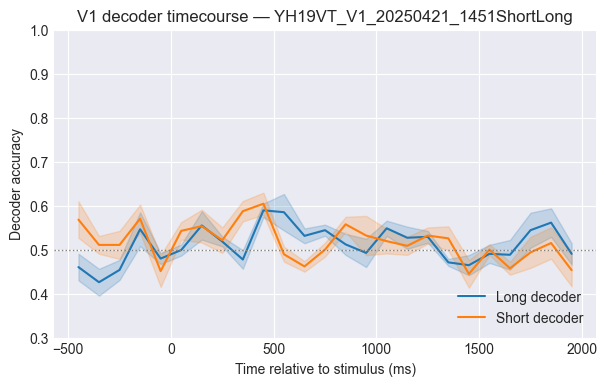

In [20]:
# Decode change vs repeat for a single V1 session (YH19VT)V1
v1_session_folder = 'YH19VT'
v1_session_name = 'YH19VT_V1_20250421_1451ShortLong'  # adjust as needed
session_path = Path('results') / v1_session_folder / v1_session_name
print(f'V1 session path: {session_path}')
if not session_path.exists():
    raise FileNotFoundError(f'Missing session folder: {session_path}')

# Trialize (re-runs safely if data already present) and load raw trial data
ops_v1 = read_ops([str(session_path)])[0]
Trialization.run(ops_v1)
neural_trials_v1 = read_neural_trials(ops_v1, smooth=False)
labels_v1, *_ = read_masks(ops_v1)
list_labels_v1 = [labels_v1]

alignment_v1 = run_get_stim_response('temp_ImageChangeDecoder_V1', [neural_trials_v1], expected='none')
neu_time_v1 = alignment_v1['neu_time']

# Apply the same trial selection and category filters as PPC analysis
_, neu_trial_v1, _, _ = get_neu_trial(
    alignment_v1,
    list_labels_v1,
    alignment_v1['list_stim_labels'],
    mean_sem=False,
    trial_param=TRIAL_PARAM,
    cate=[-1, 0, 1],
)
neu_list_v1, _, _, _, post_isi_v1 = neu_trial_v1
neu_array_v1 = np.asarray(neu_list_v1[0])
stim_labels_v1 = np.asarray(alignment_v1['list_stim_labels'][0])
post_isi_v1 = np.asarray(post_isi_v1[0])

mask_v1 = pick_trial(stim_labels_v1, *TRIAL_PARAM, frac=1)
selection_idx_v1 = np.where(mask_v1)[0]
dataset_v1 = prepare_session_dataset(neu_array_v1, stim_labels_v1, post_isi_v1, neu_time_v1, selection_idx_v1)
if dataset_v1 is None:
    raise RuntimeError('No valid V1 trials after dataset preparation.')

y_v1 = dataset_v1['meta']['is_transition'].astype(int).to_numpy()
metrics_v1 = binary_decoder_cv(
    dataset_v1['X_isi'],
    y_v1,
    n_splits=20,
    random_state=RANDOM_STATE,
    shuffle_baseline=SHUFFLE_BASELINE,
    downsample=True,
)
print('V1 decoder metrics:')
print({k: metrics_v1[k] for k in ['mean_acc', 'precision_mean', 'recall_mean', 'f1_mean']})
print('Confusion matrix:')
print(metrics_v1['confusion_matrix'])

timecourse_v1 = binary_timecourse_decoding(
    dataset_v1['trial_neu'],
    neu_time_v1,
    y_v1,
    block_labels=dataset_v1['meta']['block_type'].to_numpy(),
    bin_width_ms=BIN_WIDTH_MS,
    window=TIME_WINDOW_MS,
    n_splits=5,
    random_state=RANDOM_STATE,
    shuffle_baseline=SHUFFLE_BASELINE,
    downsample=True,
)
if not timecourse_v1.empty:
    df_v1 = timecourse_v1.assign(block_label=timecourse_v1['block_type'].map(BLOCK_LABELS).fillna(timecourse_v1['block_type']))
    fig, ax = plt.subplots(figsize=(7, 4))
    plot_timecourse(ax, df_v1)
    ax.set_title(f'V1 decoder timecourse — {v1_session_name}')
    ax.set_xlabel('Time relative to stimulus (ms)')
    ax.set_ylabel('Decoder accuracy')
    ax.legend(loc='lower right')
    plt.show()
else:
    print('No valid V1 time-course windows.')


In [21]:
# Orientation decoding on V1 session (multiclass)
if 'dataset_v1' not in locals():
    raise RuntimeError('Run the V1 decoder cell first to create dataset_v1.')
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import LinearSVC

ori_labels = dataset_v1['meta']['orientation_idx'].astype(int).to_numpy()
valid_mask = np.isfinite(ori_labels)
X_ori = dataset_v1['X_isi'][valid_mask]
y_ori = ori_labels[valid_mask]
unique_classes, class_counts = np.unique(y_ori, return_counts=True)
print('Orientation classes:', dict(zip(unique_classes, class_counts)))
if unique_classes.size < 2 or class_counts.min() < 2:
    raise RuntimeError('Not enough trials per orientation class for cross-validation.')
n_splits = min(20, int(class_counts.min()))
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)
accs = []
chance_accs = []
conf_total = np.zeros((unique_classes.size, unique_classes.size), dtype=int)
for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X_ori, y_ori)):
    X_train, X_test = X_ori[train_idx], X_ori[test_idx]
    y_train, y_test = y_ori[train_idx], y_ori[test_idx]
    pipeline = make_pipeline(
        StandardScaler(with_mean=True),
        LinearSVC(C=1.0, max_iter=5000, class_weight='balanced'),
    )
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accs.append(accuracy_score(y_test, y_pred))
    conf_total += confusion_matrix(y_test, y_pred, labels=unique_classes)
    rng = np.random.default_rng(RANDOM_STATE + 2000 + fold_idx)
    y_perm = rng.permutation(y_train)
    pipeline_perm = make_pipeline(
        StandardScaler(with_mean=True),
        LinearSVC(C=1.0, max_iter=5000, class_weight='balanced'),
    )
    pipeline_perm.fit(X_train, y_perm)
    y_perm_pred = pipeline_perm.predict(X_test)
    chance_accs.append(accuracy_score(y_test, y_perm_pred))
accs = np.asarray(accs)
chance_accs = np.asarray(chance_accs)
acc_mean = accs.mean()
acc_sem = accs.std(ddof=1)/np.sqrt(len(accs)) if len(accs)>1 else np.nan
chance_mean = chance_accs.mean()
chance_sem = chance_accs.std(ddof=1)/np.sqrt(len(chance_accs)) if len(chance_accs)>1 else np.nan
print(f'Orientation decoding accuracy: {acc_mean:.3f} ± {acc_sem:.3f}')
print(f'Shuffled baseline: {chance_mean:.3f} ± {chance_sem:.3f}')
print('Confusion matrix (rows=true, cols=pred):')
conf_df = pd.DataFrame(conf_total, index=[f'ori{cls}' for cls in unique_classes], columns=[f'ori{cls}' for cls in unique_classes])
display(conf_df)


Orientation classes: {np.int64(1): np.int64(497), np.int64(2): np.int64(468), np.int64(3): np.int64(608), np.int64(4): np.int64(286)}
Orientation decoding accuracy: 0.693 ± 0.011
Shuffled baseline: 0.267 ± 0.011
Confusion matrix (rows=true, cols=pred):


,ori1,ori2,ori3,ori4
ori1,348,61,53,35
ori2,59,301,63,45
ori3,48,62,452,46
ori4,34,35,29,188


In [22]:
# Build datasets per region from session_results, routing PPC vs V1 by session name
# Sessions with '_V1_' in their name are treated as V1; others as PPC.
region_data = {'PPC': [], 'V1': []}
for entry in session_entries:
    session_key = f"{entry['subject']}/{entry['session']}"
    if session_key not in session_results:
        continue
    dataset = session_results[session_key]['dataset']
    sess_name = entry['session']
    region = 'V1' if '_V1_' in sess_name else 'PPC'
    region_data[region].append({
        'session_key': session_key,
        'dataset': dataset,
        'neu_time': dataset['neu_time'],
    })
print({k: len(v) for k, v in region_data.items()})


{'PPC': 1, 'V1': 1}


In [76]:

# Define classification tasks for the analysis suite

def label_theta_change(meta):
    if 'theta_change_deg' not in meta.columns:
        return pd.Series([np.nan] * len(meta), index=meta.index)
    theta = meta['theta_change_deg'].astype(float)
    theta = theta.where(np.isfinite(theta))
    quantised = (np.round(theta / 45.0) * 45.0).clip(lower=0.0, upper=90.0)
    return quantised

classification_suite = [
    {
        'name': 'change_vs_repeat',
        'label': 'Change vs Repeat',
        'kind': 'binary',
        'label_fn': lambda meta: meta['is_transition'].astype(int),
    },
    {
        'name': 'orientation',
        'label': 'Orientation',
        'kind': 'multiclass',
        'label_fn': lambda meta: meta['orientation_idx'],
    },
    # {
    #     'name': 'to_or_repeat',
    #     'label': 'To-orientation vs Repeat-by-orientation',
    #     'kind': 'multiclass',
    #     'label_fn': lambda meta: (pd.Series(np.where(meta['is_transition'], 'to_', 'repeat_')) + meta['orientation_idx'].astype(int).astype(str)),
    # },
    {
        'name': 'theta_change',
        'label': 'Δθ (deg)',
        'kind': 'multiclass',
        'label_fn': label_theta_change,
    },
    # {
    #     'name': 'change_pair',
    #     'label': 'Change pair / repeat class',
    #     'kind': 'multiclass',
    #     'label_fn': lambda meta: meta['pair_label'],
    # },
]



In [77]:
import time
suite_results = {}
for region, sessions in region_data.items():
    region_results = {}
    n_splits_default = 20
    for task in classification_suite:
        session_metrics = []
        timecourse_tables = []
        for sess in sessions:
            dataset = sess['dataset']
            meta = dataset['meta']
            # Build labels per task
            try:
                labels_obj = task['label_fn'](meta)
            except KeyError:
                continue
            # Drop ultra-rare classes for change-pair
            if task['name'] == 'change_pair':
                ser_all = pd.Series(labels_obj)
                vc = ser_all.value_counts()
                keep = vc[vc >= 5].index
                ser_all = ser_all.where(ser_all.isin(keep))
            else:
                ser_all = pd.Series(labels_obj)
            # Choose per-task folds
            n_splits_task = 5 if task['name'] == 'change_pair' else n_splits_default
            # Choose lighter folds for timecourse by task
            if task['name'] == 'change_vs_repeat':
                n_splits_task_tc = 10
            elif task['name'] in ('orientation','to_or_repeat','theta_change','change_pair'):
                n_splits_task_tc = 5
            else:
                n_splits_task_tc = n_splits_task
            if task['kind'] == 'binary':
                mask = ser_all.notna()
                if mask.sum() < 2:
                    continue
                X = dataset['X_isi'][mask.to_numpy()]
                y = ser_all[mask].astype(int).to_numpy()
                if np.unique(y).size < 2:
                    continue
                t0 = time.perf_counter()
                print(f"[{region}] {task['label']} — {sess['session_key']} (n_trials={X.shape[0]})")
                metrics = binary_decoder_cv(
                    X, y,
                    n_splits=n_splits_task,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                    downsample=True,
                    progress_desc=f"{region}|{task['name']}|{sess['session_key']}",
                )
                if metrics is None:
                    continue
                t1 = time.perf_counter()
                print(f"    finished CV in {t1-t0:.2f}s: acc={metrics['mean_acc']:.3f} chance={metrics['mean_chance'] if metrics['mean_chance']==metrics['mean_chance'] else float('nan'):.3f}")
                print(f"    starting timecourse ({n_splits_task_tc} folds, {BIN_WIDTH_MS} ms bins) ...")
                tc = binary_timecourse_decoding(
                    dataset['trial_neu'][mask.to_numpy()],
                    sess['neu_time'],
                    y,
                    block_labels=meta['block_type'].to_numpy()[mask.to_numpy()],
                    bin_width_ms=BIN_WIDTH_MS,
                    window=TIME_WINDOW_MS,
                    n_splits=n_splits_task,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                    downsample=True,
                )
                class_labels = [0, 1]
            else:
                labels_series = ser_all
                mask = labels_series.notna()
                if mask.sum() < 2:
                    continue
                values = labels_series[mask]
                codes, uniques = pd.factorize(values)
                if np.unique(codes).size < 2:
                    continue
                X = dataset['X_isi'][mask.to_numpy()]
                y = codes
                t0 = time.perf_counter()
                print(f"[{region}] {task['label']} — {sess['session_key']} (n_trials={X.shape[0]})")
                metrics = multiclass_decoder_cv(
                    X, y,
                    n_splits=n_splits_task,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                    progress_desc=f"{region}|{task['name']}|{sess['session_key']}",
                )
                if metrics is None:
                    continue
                t1 = time.perf_counter()
                print(f"    finished CV in {t1-t0:.2f}s: acc={metrics['mean_acc']:.3f} chance={metrics['mean_chance'] if metrics['mean_chance']==metrics['mean_chance'] else float('nan'):.3f}")
                print(f"    starting timecourse ({n_splits_task_tc} folds, {BIN_WIDTH_MS} ms bins) ...")
                tc = multiclass_timecourse_decoding(
                    dataset['trial_neu'][mask.to_numpy()],
                    sess['neu_time'],
                    y,
                    block_labels=meta['block_type'].to_numpy()[mask.to_numpy()],
                    bin_width_ms=BIN_WIDTH_MS,
                    window=TIME_WINDOW_MS,
                    n_splits=n_splits_task,
                    random_state=RANDOM_STATE,
                    shuffle_baseline=SHUFFLE_BASELINE,
                )
                if isinstance(tc, pd.DataFrame):
                    n_bins = int(tc['time_center_ms'].nunique()) if not tc.empty else 0
                else:
                    n_bins = 0
                # simple elapsed from previous t1 stamp
                t_tc1 = time.perf_counter()
                print(f"    finished timecourse in {t_tc1 - t1:.2f}s; bins={n_bins}")
                class_labels = [str(u) for u in uniques]
                metrics['class_labels'] = class_labels
            session_metrics.append({
                'session_key': sess['session_key'],
                'n_trials': int(X.shape[0]),
                'accuracy_mean': metrics['mean_acc'],
                'accuracy_sem': metrics['sem_acc'],
                'chance_mean': metrics['mean_chance'],
                'chance_sem': metrics['sem_chance'],
                'precision_mean': metrics.get('precision_mean'),
                'precision_sem': metrics.get('precision_sem'),
                'recall_mean': metrics.get('recall_mean'),
                'recall_sem': metrics.get('recall_sem'),
                'f1_mean': metrics.get('f1_mean'),
                'f1_sem': metrics.get('f1_sem'),
                'class_labels': class_labels,
                'confusion_matrix': metrics['confusion_matrix'].tolist(),
            })
            if not tc.empty:
                tc = tc.assign(session=sess['session_key'], region=region, task=task['label'])
                timecourse_tables.append(tc)
        region_results[task['label']] = {
            'session_metrics': pd.DataFrame(session_metrics),
            'timecourse': pd.concat(timecourse_tables, ignore_index=True) if timecourse_tables else pd.DataFrame(),
        }
    suite_results[region] = region_results
suite_results



[PPC] Change vs Repeat — YH02VT/VTYH02_PPC_20250228_1451ShortLong (n_trials=1848)


PPC|change_vs_repeat|YH02VT/VTYH02_PPC_20250228_1451ShortLong:   0%|          | 0/20 [00:00<?, ?it/s]

    finished CV in 0.44s: acc=0.509 chance=0.514
    starting timecourse (10 folds, 100.0 ms bins) ...
[PPC] Orientation — YH02VT/VTYH02_PPC_20250228_1451ShortLong (n_trials=1848)


PPC|orientation|YH02VT/VTYH02_PPC_20250228_1451ShortLong:   0%|          | 0/20 [00:00<?, ?it/s]

    finished CV in 2.19s: acc=0.281 chance=0.242
    starting timecourse (5 folds, 100.0 ms bins) ...
    finished timecourse in 34.60s; bins=25
[V1] Change vs Repeat — YH19VT/YH19VT_V1_20250421_1451ShortLong (n_trials=1859)


V1|change_vs_repeat|YH19VT/YH19VT_V1_20250421_1451ShortLong:   0%|          | 0/20 [00:00<?, ?it/s]

    finished CV in 0.41s: acc=0.590 chance=0.519
    starting timecourse (10 folds, 100.0 ms bins) ...
[V1] Orientation — YH19VT/YH19VT_V1_20250421_1451ShortLong (n_trials=1859)


V1|orientation|YH19VT/YH19VT_V1_20250421_1451ShortLong:   0%|          | 0/20 [00:00<?, ?it/s]

    finished CV in 15.00s: acc=0.693 chance=0.246
    starting timecourse (5 folds, 100.0 ms bins) ...
    finished timecourse in 655.30s; bins=25


{'PPC': {'Change vs Repeat': {'session_metrics':                                 session_key  n_trials  accuracy_mean  \
   0  YH02VT/VTYH02_PPC_20250228_1451ShortLong      1848       0.508919   
   
      accuracy_sem  chance_mean  chance_sem  precision_mean  precision_sem  \
   0      0.011595     0.513784    0.011503        0.031202        0.00307   
   
      recall_mean  recall_sem   f1_mean    f1_sem class_labels  \
   0        0.475    0.050255  0.058517  0.005777       [0, 1]   
   
              confusion_matrix  
   0  [[1826, 1754], [63, 57]]  ,
   'timecourse':     block_type  time_start_ms  time_center_ms  time_stop_ms  accuracy_mean  \
   0            0         -500.0          -450.0        -400.0       0.539247   
   1            0         -400.0          -350.0        -300.0       0.481720   
   2            0         -300.0          -250.0        -200.0       0.488172   
   3            0         -200.0          -150.0        -100.0       0.457527   
   4            0 

In [96]:
# Ensure each session metrics table contains confusion_matrix column
for region, task_dict in suite_results.items():
    for task_label, payload in task_dict.items():
        df = payload.get('session_metrics')
        if df is None or df.empty:
            continue
        if 'confusion_matrix' not in df.columns:
            df['confusion_matrix'] = [[None]] * len(df)
        else:
            df['confusion_matrix'] = df['confusion_matrix'].apply(lambda cm: cm if isinstance(cm, list) else None)
            if df['confusion_matrix'].isna().any():
                df.loc[df['confusion_matrix'].isna(), 'confusion_matrix'] = [[None]] * df['confusion_matrix'].isna().sum()


=== PPC ===


,session_key,n_trials,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,class_labels,confusion_matrix
0,YH02VT/VTYH02_PPC_20250228_1451ShortLong,1848,0.508919,0.011595,0.513784,0.011503,0.031202,0.00307,0.475,0.050255,0.058517,0.005777,"[0, 1]","[[1826, 1754], [63, 57]]"


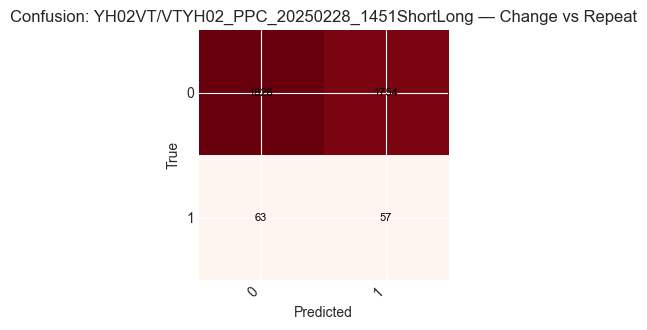

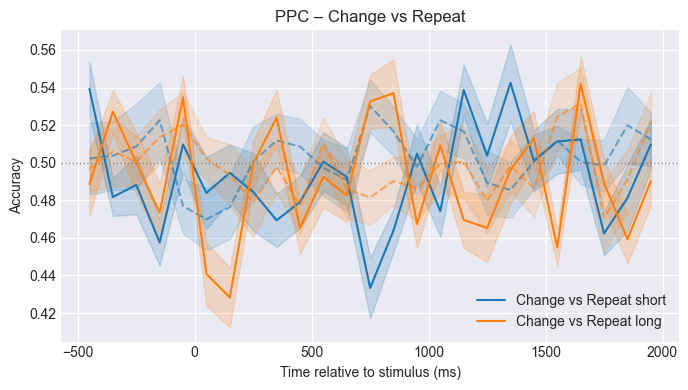

,session_key,n_trials,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,class_labels,confusion_matrix
0,YH02VT/VTYH02_PPC_20250228_1451ShortLong,1848,0.280844,0.010077,0.24193,0.008577,0.27966,0.01094,0.280508,0.010066,0.276951,0.010116,"[3, 4, 2, 1]","[[114, 122, 126, 89], [111, 131, 106, 106], [1..."


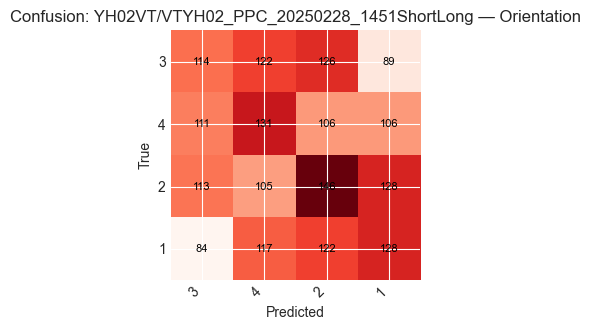

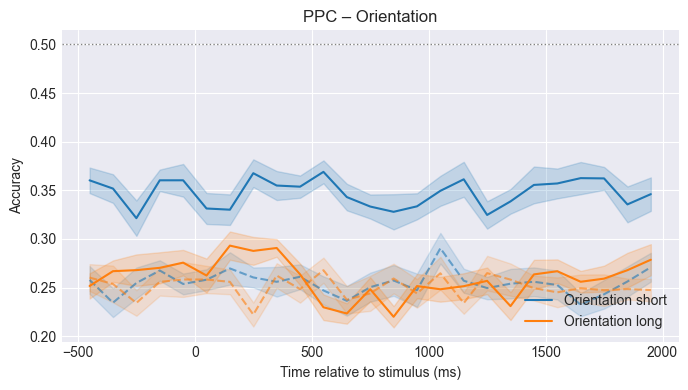

  Δθ (deg): no valid sessions
=== V1 ===


,session_key,n_trials,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,class_labels,confusion_matrix
0,YH19VT/YH19VT_V1_20250421_1451ShortLong,1859,0.589516,0.010783,0.518817,0.009308,0.048414,0.003246,0.616667,0.036475,0.08972,0.005949,"[0, 1]","[[2119, 1481], [46, 74]]"


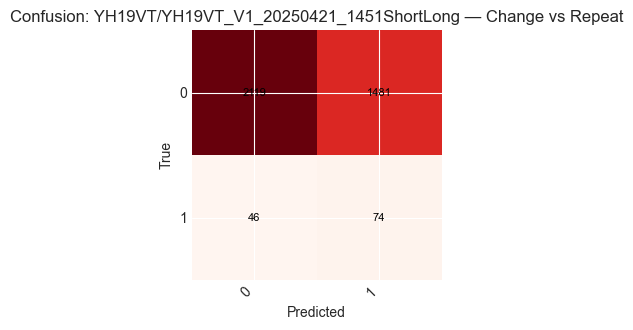

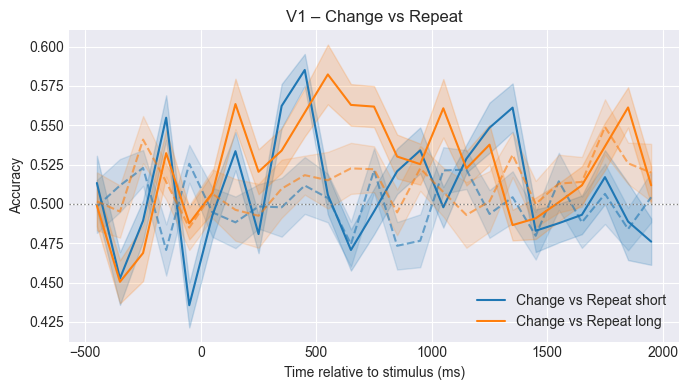

,session_key,n_trials,accuracy_mean,accuracy_sem,chance_mean,chance_sem,precision_mean,precision_sem,recall_mean,recall_sem,f1_mean,f1_sem,class_labels,confusion_matrix
0,YH19VT/YH19VT_V1_20250421_1451ShortLong,1859,0.69332,0.01117,0.246435,0.011061,0.684067,0.011707,0.686537,0.012437,0.681631,0.012111,"[2, 3, 4, 1]","[[301, 63, 45, 59], [62, 452, 46, 48], [35, 29..."


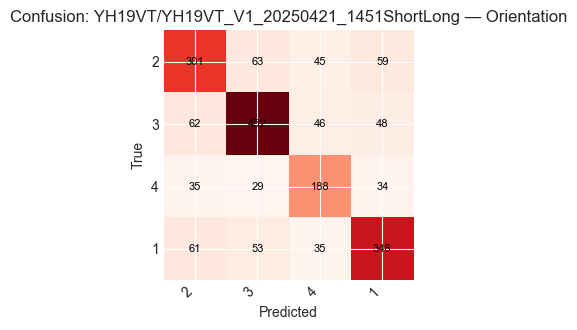

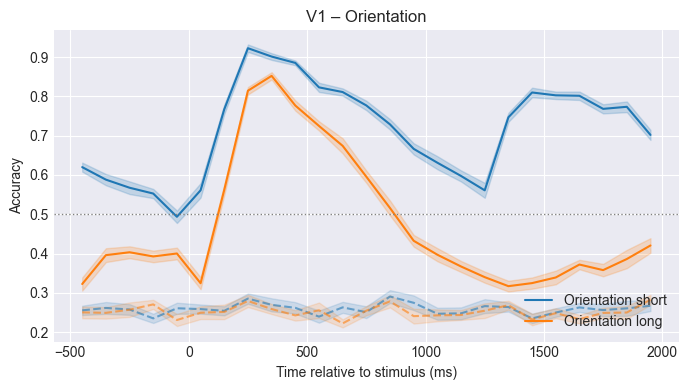

  Δθ (deg): no valid sessions


In [98]:

block_name = {0: 'short', 1: 'long'}
save_suite_plots = False
for region, task_dict in suite_results.items():
    print(f'=== {region} ===')
    for task_label, payload in task_dict.items():
        df = payload['session_metrics']
        if df.empty:
            print(f'  {task_label}: no valid sessions')
            continue
        display(df)
        if 'confusion_matrix' in df.columns:
            for _, row in df.iterrows():
                cm = row.get('confusion_matrix')
                if cm is None:
                    continue
                try:
                    cm_arr = np.array(cm, dtype=float)
                except (TypeError, ValueError):
                    continue
                if cm_arr.size == 0 or cm_arr.ndim != 2:
                    continue
                fig_cm, ax_cm = plt.subplots(figsize=(3.8, 3.4))
                im = ax_cm.imshow(cm_arr, cmap='Reds')
                labels_col = row.get('class_labels')
                if isinstance(labels_col, list) and len(labels_col) == cm_arr.shape[0]:
                    ticklabs = [str(x) for x in labels_col]
                else:
                    ticklabs = [str(i) for i in range(cm_arr.shape[0])]
                ax_cm.set_xticks(range(cm_arr.shape[1]))
                ax_cm.set_yticks(range(cm_arr.shape[0]))
                ax_cm.set_xticklabels(ticklabs, rotation=45, ha='right')
                ax_cm.set_yticklabels(ticklabs)
                ax_cm.set_xlabel('Predicted')
                ax_cm.set_ylabel('True')
                for (ii, jj), val in np.ndenumerate(cm_arr):
                    ax_cm.text(jj, ii, int(val), ha='center', va='center', color='black', fontsize=8)
                title_txt = 'Confusion: {} — {}'.format(row['session_key'], task_label)
                ax_cm.set_title(title_txt)
                plt.tight_layout()
                plt.show()
                plt.close(fig_cm)
        tc = payload['timecourse']
        if not tc.empty:
            fig, ax = plt.subplots(figsize=(7, 4))
            df_plot = (
                tc.groupby(['task', 'block_type', 'time_center_ms'])
                  .agg(
                      acc_mean=('accuracy_mean', 'mean'),
                      acc_sem=('accuracy_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
                      chance_mean=('chance_mean', 'mean'),
                      chance_sem=('chance_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
                  )
                  .reset_index()
            )
            color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0']))
            for block, sub in df_plot.groupby('block_type'):
                color = next(color_cycle)
                label_block = block_name.get(int(block), f'block {block}')
                ax.plot(sub['time_center_ms'], sub['acc_mean'], label=f'{task_label} {label_block}', color=color)
                ax.fill_between(sub['time_center_ms'], sub['acc_mean'] - sub['acc_sem'], sub['acc_mean'] + sub['acc_sem'], color=color, alpha=0.2)
                ax.plot(sub['time_center_ms'], sub['chance_mean'], linestyle='--', color=color, alpha=0.6)
                ax.fill_between(sub['time_center_ms'], sub['chance_mean'] - sub['chance_sem'], sub['chance_mean'] + sub['chance_sem'], color=color, alpha=0.15)
            ax.axhline(0.5, color='grey', linestyle=':', linewidth=1)
            ax.set_title(f'{region} – {task_label}')
            ax.set_xlabel('Time relative to stimulus (ms)')
            ax.set_ylabel('Accuracy')
            ax.legend(loc='lower right')
            plt.tight_layout()
            plt.show()
            plt.close(fig)



In [80]:

# Orientation-specific binary decoders: to-k vs repeat-k per session/region
from modeling.decoding import binary_decoder_cv, binary_timecourse_decoding
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle


def run_to_vs_repeat_per_orientation(
    session_key,
    dataset,
    neu_time,
    n_splits_pooled=20,
    n_splits_tc=5,
    bin_width_ms=BIN_WIDTH_MS,
    window=TIME_WINDOW_MS,
    shuffle_baseline=SHUFFLE_BASELINE,
    downsample=True,
    show_tc_progress=False,
    pca_n_components=None,
    region=None,
    save_plots=False,
    plot_category='to_vs_repeat',
):
    meta = dataset['meta']
    unique_oris = np.sort(meta['orientation_idx'].unique().astype(int))
    results_rows = []
    per_session_timecourses = []

    def _save(fig, name):
        if not save_plots:
            return None
        parts = [region or 'unspecified_region', plot_category, session_key]

    for k in unique_oris:
        mask = (meta['orientation_idx'] == k)
        if mask.sum() < 3:
            continue
        y = meta.loc[mask, 'is_transition'].astype(int).to_numpy()  # 1=to k, 0=repeat k
        X = dataset['X_isi'][mask.to_numpy()]
        if np.unique(y).size < 2 or np.bincount(y).min() < 2:
            continue
        metrics = binary_decoder_cv(
            X,
            y,
            n_splits=n_splits_pooled,
            random_state=RANDOM_STATE,
            shuffle_baseline=shuffle_baseline,
            downsample=downsample,
            progress_desc=f"{session_key}|to_vs_repeat_k={k}",
            pca_n_components=pca_n_components,
        )
        cm = metrics['confusion_matrix']
        fig_cm, ax_cm = plt.subplots(figsize=(3.8, 3.4))
        ax_cm.imshow(cm, cmap='Blues')
        ax_cm.set_xticks([0, 1]); ax_cm.set_yticks([0, 1])
        ax_cm.set_xticklabels(['repeat_k', 'to_k'], rotation=45, ha='right')
        ax_cm.set_yticklabels(['repeat_k', 'to_k'])
        for (ii, jj), val in np.ndenumerate(cm):
            ax_cm.text(jj, ii, int(val), ha='center', va='center', color='black', fontsize=8)
        ax_cm.set_xlabel('Predicted'); ax_cm.set_ylabel('True')
        ax_cm.set_title(f'Confusion: {session_key} — to/repeat k={k}')
        plt.tight_layout()
        _save(fig_cm, f'confusion_k{k}')
        plt.show()
        plt.close(fig_cm)

        results_rows.append({
            'session_key': session_key,
            'orientation_k': int(k),
            'n_trials': int(X.shape[0]),
            'n_neurons': int(X.shape[1]),
            'pos_frac_to_k': float(y.mean()),
            'accuracy_mean': metrics['mean_acc'],
            'accuracy_sem': metrics['sem_acc'],
            'chance_mean': metrics['mean_chance'],
            'chance_sem': metrics['sem_chance'],
            'precision_mean': metrics.get('precision_mean'),
            'precision_sem': metrics.get('precision_sem'),
            'recall_mean': metrics.get('recall_mean'),
            'recall_sem': metrics.get('recall_sem'),
            'f1_mean': metrics.get('f1_mean'),
            'f1_sem': metrics.get('f1_sem'),
            'n_splits': metrics['n_splits'],
        })

        tc = binary_timecourse_decoding(
            dataset['trial_neu'][mask.to_numpy()],
            neu_time,
            y,
            block_labels=meta.loc[mask, 'block_type'].to_numpy(),
            bin_width_ms=bin_width_ms,
            window=window,
            n_splits=n_splits_tc,
            random_state=RANDOM_STATE,
            shuffle_baseline=shuffle_baseline,
            downsample=downsample,
            show_progress=show_tc_progress,
            progress_label=f"{session_key}|k={k}",
            pca_n_components=pca_n_components,
        )
        tc = tc.assign(orientation_k=int(k))
        if not tc.empty:
            df_plot = (
                tc.groupby(['orientation_k', 'block_type', 'time_center_ms'])
                  .agg(
                      acc_mean=('accuracy_mean', 'mean'),
                      acc_sem=('accuracy_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
                      chance_mean=('chance_mean', 'mean'),
                      chance_sem=('chance_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
                  )
                  .reset_index()
            )
            block_name = {0: 'short', 1: 'long'}
            block_color = {0: 'tab:blue', 1: 'tab:orange'}
            for ori_k, df_k in df_plot.groupby('orientation_k'):
                fig_k, ax_k = plt.subplots(figsize=(7, 4))
                for block, sub in df_k.groupby('block_type'):
                    color = block_color.get(int(block), None) or next(cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0'])))
                    label_block = block_name.get(int(block), f'block {block}')
                    ax_k.plot(sub['time_center_ms'], sub['acc_mean'], label=f'k={ori_k} {label_block}', color=color)
                    ax_k.fill_between(sub['time_center_ms'], sub['acc_mean'] - sub['acc_sem'], sub['acc_mean'] + sub['acc_sem'], color=color, alpha=0.2)
                    ax_k.plot(sub['time_center_ms'], sub['chance_mean'], linestyle='--', color=color, alpha=0.6)
                    ax_k.fill_between(sub['time_center_ms'], sub['chance_mean'] - sub['chance_sem'], sub['chance_mean'] + sub['chance_sem'], color=color, alpha=0.15)
                ax_k.axhline(0.5, color='grey', linestyle=':', linewidth=1)
                ax_k.set_title(f'Timecourse: to_k vs repeat_k — {session_key} (k={ori_k})')
                ax_k.set_xlabel('Time relative to stimulus (ms)')
                ax_k.set_ylabel('Accuracy')
                ax_k.legend(loc='lower right')
                plt.tight_layout()
                _save(fig_k, f'timecourse_k{ori_k}')
                plt.show()
                plt.close(fig_k)
            per_session_timecourses.append(tc)

    results_df = pd.DataFrame(results_rows)
    to_vs_repeat_timecourses = pd.concat(per_session_timecourses, ignore_index=True) if per_session_timecourses else pd.DataFrame()
    print('Summary rows:', len(results_df), 'timecourse rows:', len(to_vs_repeat_timecourses))
    return results_df, to_vs_repeat_timecourses



YH19VT_V1_20250421_1451ShortLong|to_vs_repeat_k=1:   0%|          | 0/18 [00:00<?, ?it/s]

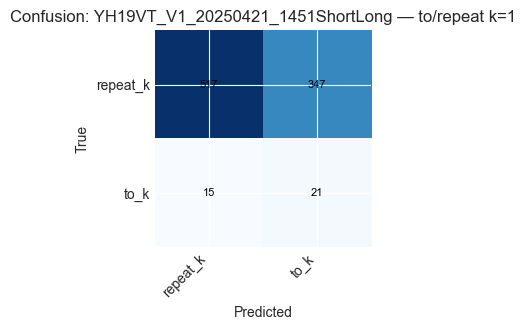

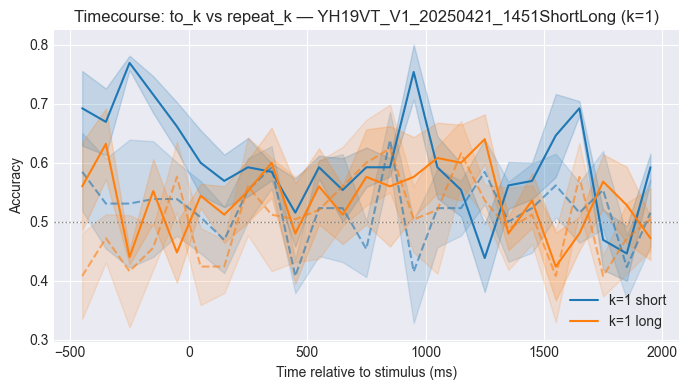

YH19VT_V1_20250421_1451ShortLong|to_vs_repeat_k=2:   0%|          | 0/14 [00:00<?, ?it/s]

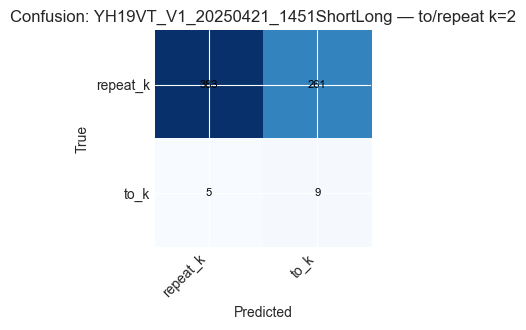

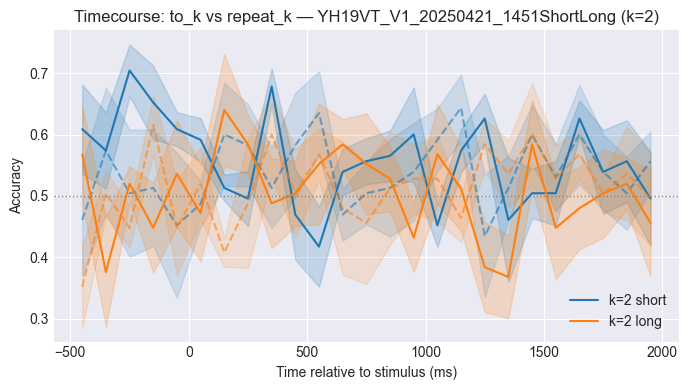

YH19VT_V1_20250421_1451ShortLong|to_vs_repeat_k=3:   0%|          | 0/20 [00:00<?, ?it/s]

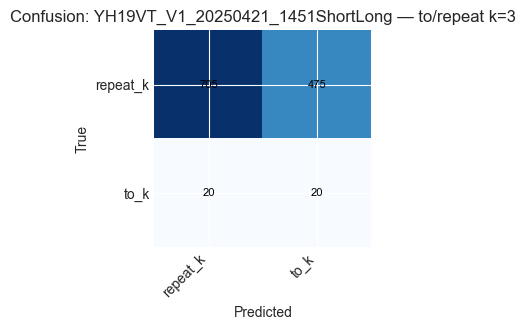

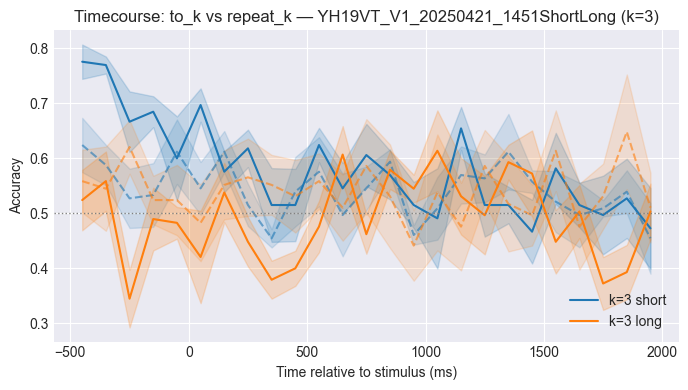

YH19VT_V1_20250421_1451ShortLong|to_vs_repeat_k=4:   0%|          | 0/11 [00:00<?, ?it/s]

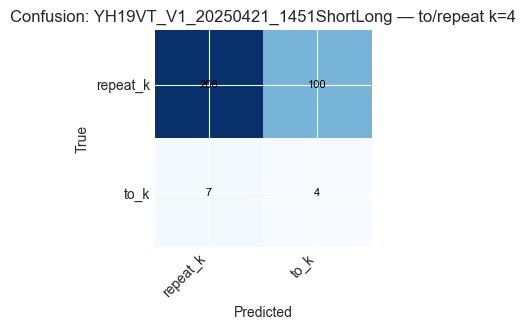

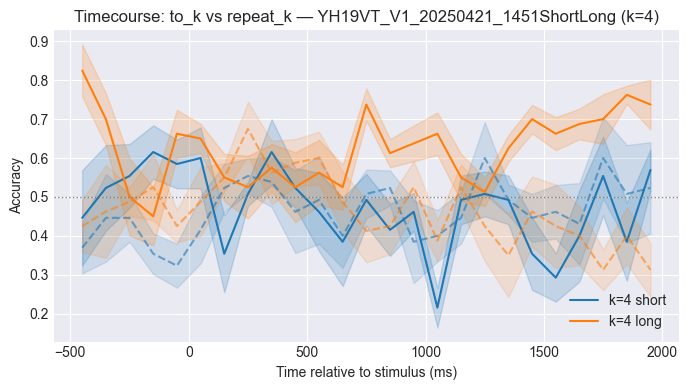

Summary rows: 4 timecourse rows: 200


(                        session_key  orientation_k  n_trials  n_neurons  \
 0  YH19VT_V1_20250421_1451ShortLong              1       497        265   
 1  YH19VT_V1_20250421_1451ShortLong              2       468        265   
 2  YH19VT_V1_20250421_1451ShortLong              3       608        265   
 3  YH19VT_V1_20250421_1451ShortLong              4       286        265   
 
    pos_frac_to_k  accuracy_mean  accuracy_sem  chance_mean  chance_sem  \
 0       0.036217       0.597778      0.021013     0.490000    0.027641   
 1       0.029915       0.595745      0.019187     0.500000    0.035459   
 2       0.032895       0.594262      0.018227     0.513934    0.018512   
 3       0.038462       0.664577      0.032578     0.489028    0.033146   
 
    precision_mean  precision_sem  recall_mean  recall_sem   f1_mean    f1_sem  \
 0        0.056822       0.007554     0.583333    0.072873  0.103325  0.013644   
 1        0.034542       0.007608     0.642857    0.132894  0.065411  0.01430

In [81]:
# Run orientation-specific to_vs_repeat decoder for the prepared V1 dataset
if 'dataset_v1' not in locals():
    raise RuntimeError('Run the V1 dataset preparation cell first.')
if 'neu_time_v1' not in locals():
    raise RuntimeError('Missing neu_time_v1; rerun the V1 preparation cell.')
run_to_vs_repeat_per_orientation(
    session_key=v1_session_name,
    dataset=dataset_v1,
    neu_time=neu_time_v1,
    n_splits_pooled=20,
    n_splits_tc=5,
    show_tc_progress=False,
)


YH02VT/VTYH02_PPC_20250228_1451ShortLong|to_vs_repeat_k=1:   0%|          | 0/18 [00:00<?, ?it/s]

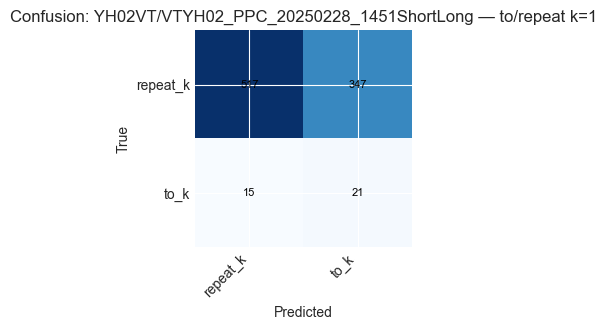

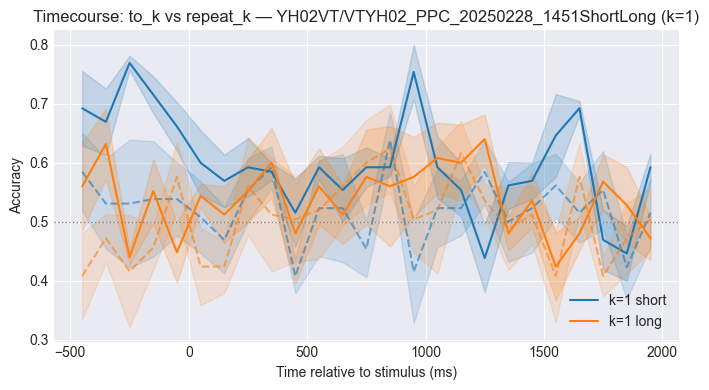

YH02VT/VTYH02_PPC_20250228_1451ShortLong|to_vs_repeat_k=2:   0%|          | 0/14 [00:00<?, ?it/s]

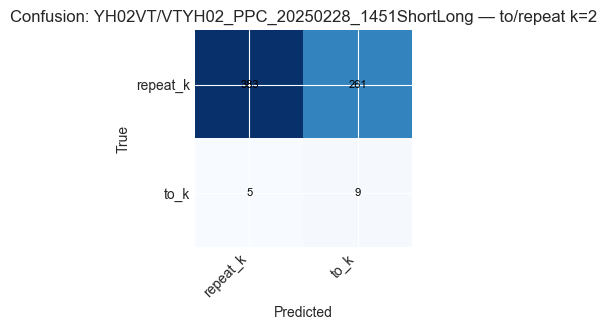

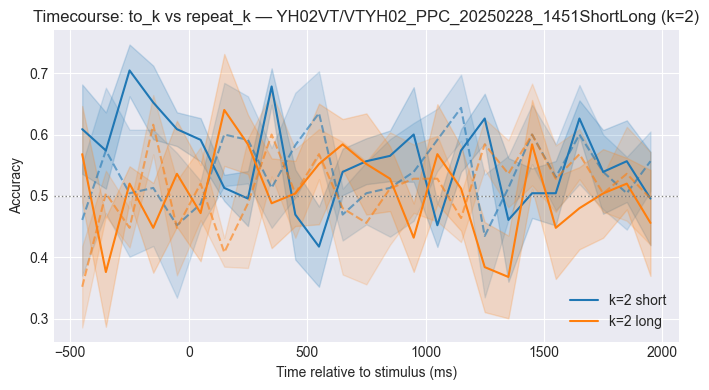

YH02VT/VTYH02_PPC_20250228_1451ShortLong|to_vs_repeat_k=3:   0%|          | 0/20 [00:00<?, ?it/s]

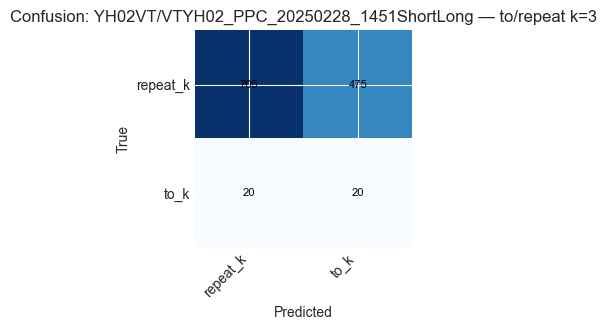

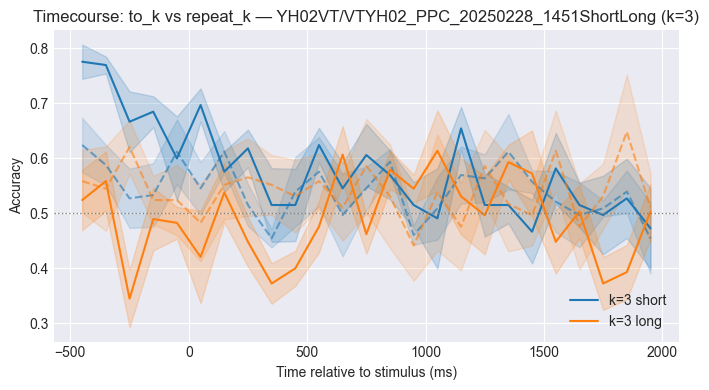

YH02VT/VTYH02_PPC_20250228_1451ShortLong|to_vs_repeat_k=4:   0%|          | 0/11 [00:00<?, ?it/s]

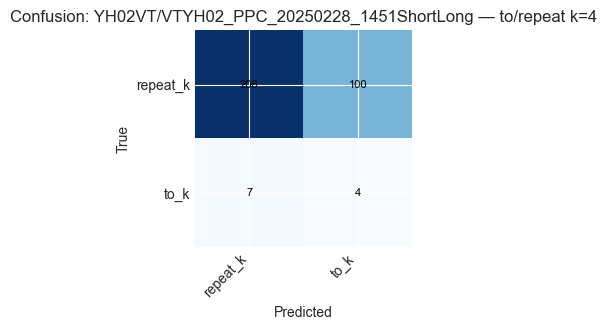

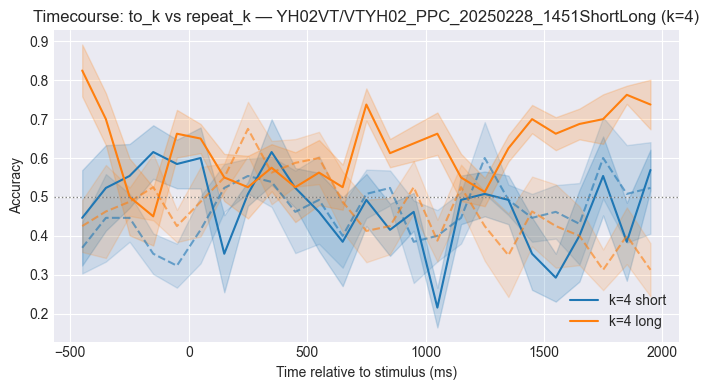

Summary rows: 4 timecourse rows: 200


(                                session_key  orientation_k  n_trials  \
 0  YH02VT/VTYH02_PPC_20250228_1451ShortLong              1       497   
 1  YH02VT/VTYH02_PPC_20250228_1451ShortLong              2       468   
 2  YH02VT/VTYH02_PPC_20250228_1451ShortLong              3       608   
 3  YH02VT/VTYH02_PPC_20250228_1451ShortLong              4       286   
 
    n_neurons  pos_frac_to_k  accuracy_mean  accuracy_sem  chance_mean  \
 0        265       0.036217       0.597778      0.021013     0.490000   
 1        265       0.029915       0.595745      0.019187     0.500000   
 2        265       0.032895       0.594262      0.018227     0.513934   
 3        265       0.038462       0.664577      0.032578     0.489028   
 
    chance_sem  precision_mean  precision_sem  recall_mean  recall_sem  \
 0    0.027641        0.056822       0.007554     0.583333    0.072873   
 1    0.035459        0.034542       0.007608     0.642857    0.132894   
 2    0.018512        0.039855       0.

In [82]:
run_to_vs_repeat_per_orientation(
    session_key="YH02VT/VTYH02_PPC_20250228_1451ShortLong",
    dataset=dataset,
    neu_time=neu_time,
    n_splits_pooled=20,
    n_splits_tc=5,
    show_tc_progress=False,
)

'YH19VT/YH19VT_V1_20250421_1451ShortLong'

YH02VT/VTYH02_PPC_20250228_1451ShortLong|to_vs_repeat_k=1:   0%|          | 0/15 [00:00<?, ?it/s]

NameError: name 'save_figure' is not defined

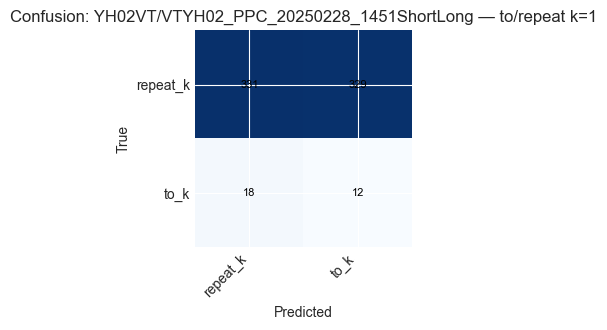

In [83]:

# Orientation-specific to_k vs repeat_k decoding per region
region_orientation_results = {}
region_orientation_timecourses = {}
save_orientation_plots = False

for region, sessions in region_data.items():
    region_rows = []
    region_tcs = []
    for sess in sessions:
        sess_key = sess['session_key']
        ds = sess['dataset']
        neu_time_local = sess.get('neu_time', ds.get('neu_time'))
        if neu_time_local is None:
            neu_time_local = ds.get('neu_time')
        if neu_time_local is None:
            raise RuntimeError(f'Missing neu_time for session {sess_key}')
        results_df, tc_df = run_to_vs_repeat_per_orientation(
            session_key=sess_key,
            dataset=ds,
            neu_time=neu_time_local,
            n_splits_pooled=20,
            n_splits_tc=5,
            show_tc_progress=False,
            region=region,
            save_plots=save_orientation_plots,
            plot_category='to_or_repeat',
        )
        if not results_df.empty:
            region_rows.append(results_df.assign(region=region))
        if not tc_df.empty:
            region_tcs.append(tc_df.assign(region=region, session_key=sess_key))
    region_orientation_results[region] = pd.concat(region_rows, ignore_index=True) if region_rows else pd.DataFrame()
    region_orientation_timecourses[region] = pd.concat(region_tcs, ignore_index=True) if region_tcs else pd.DataFrame()

region_orientation_results



In [84]:

# Averaged to_k vs repeat_k timecourses per region
if not region_orientation_timecourses:
    raise RuntimeError('Run the region_orientation_results cell first to populate timecourses.')

save_avg_orientation_plots = False
for region, tc_df in region_orientation_timecourses.items():
    if tc_df.empty:
        print(f'{region}: no valid timecourses to plot.')
        continue
    fig, ax = plt.subplots(figsize=(7, 4))
    df_avg = (
        tc_df.groupby(['block_type', 'time_center_ms'])
          .agg(
              acc_mean=('accuracy_mean', 'mean'),
              acc_sem=('accuracy_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
              chance_mean=('chance_mean', 'mean'),
              chance_sem=('chance_sem', lambda x: np.sqrt(np.mean(np.square(x)))),
          )
          .reset_index()
    )
    if df_avg.empty:
        plt.close(fig)
        print(f'{region}: aggregated timecourse empty after grouping.')
        continue
    block_name = {0: 'short', 1: 'long'}
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key().get('color', ['C0']))
    for block, sub in df_avg.groupby('block_type'):
        color = next(color_cycle)
        label_block = block_name.get(int(block), f'block {block}')
        ax.plot(sub['time_center_ms'], sub['acc_mean'], label=label_block, color=color)
        ax.fill_between(sub['time_center_ms'], sub['acc_mean'] - sub['acc_sem'], sub['acc_mean'] + sub['acc_sem'], color=color, alpha=0.2)
        ax.plot(sub['time_center_ms'], sub['chance_mean'], linestyle='--', color=color, alpha=0.6)
        ax.fill_between(sub['time_center_ms'], sub['chance_mean'] - sub['chance_sem'], sub['chance_mean'] + sub['chance_sem'], color=color, alpha=0.15)
    ax.axhline(0.5, color='grey', linestyle=':', linewidth=1)
    ax.set_title(f'Avg timecourse: to_k vs repeat_k — {region}')
    ax.set_xlabel('Time relative to stimulus (ms)')
    ax.set_ylabel('Accuracy')
    ax.legend(loc='lower right')
    plt.tight_layout()
    if save_avg_orientation_plots:
    plt.show()
    plt.close(fig)



RuntimeError: Run the region_orientation_results cell first to populate timecourses.

/var/folders/6s/3wb2h2qd7dj2dln0h5wk8bs40000gn/T/ipykernel_31863/4096236238.py:34: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'transitions': int(transition_counts.get(True, transition_counts.get(1, 0))),
/var/folders/6s/3wb2h2qd7dj2dln0h5wk8bs40000gn/T/ipykernel_31863/4096236238.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  'repeats': int(transition_counts.get(False, transition_counts.get(0, 0))),


YH02VT/VTYH02_PPC_20250228_1451ShortLong|to_vs_repeat_k=1:   0%|          | 0/15 [00:00<?, ?it/s]

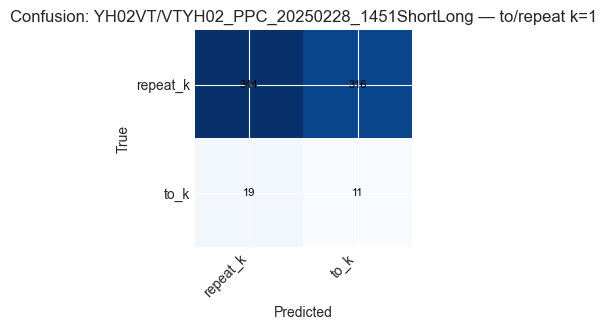

ValueError: n_components=20 must be between 0 and min(n_samples, n_features)=8 with svd_solver='full'

In [101]:
# PPC diagnostics: summary stats and extended-parameter decoder runs
if 'region_data' not in globals():
    raise RuntimeError('Run the data loading cells before the diagnostics.')

ppc_sessions = region_data.get('PPC', [])
if not ppc_sessions:
    print('No PPC sessions available for diagnostics.')
else:
    diag_rows = []
    ppc_diag_results = {}
    save_ppc_diag_plots = True
    for sess in ppc_sessions:
        sess_key = sess['session_key']
        ds = sess['dataset']
        meta = ds['meta']
        n_trials, n_neurons = ds['X_isi'].shape
        transition_counts = meta['is_transition'].value_counts()
        ori_counts = (
            meta.groupby(['orientation_idx', 'is_transition'])
                .size()
                .unstack(fill_value=0)
        )
        ori_totals = ori_counts.sum(axis=1) if not ori_counts.empty else pd.Series(dtype=float)
        post_isi_stats = meta['post_isi_ms'].describe()
        median_post_isi = float(post_isi_stats['50%']) if '50%' in post_isi_stats else float('nan')
        q75 = post_isi_stats['75%'] if '75%' in post_isi_stats else np.nan
        q25 = post_isi_stats['25%'] if '25%' in post_isi_stats else np.nan
        post_isi_iqr = float(q75 - q25) if np.isfinite(q75) and np.isfinite(q25) else float('nan')
        min_trials_orientation = int(ori_totals.min()) if not ori_totals.empty else n_trials
        diag_rows.append({
            'session_key': sess_key,
            'n_trials': int(n_trials),
            'n_neurons': int(n_neurons),
            'transitions': int(transition_counts.get(True, transition_counts.get(1, 0))),
            'repeats': int(transition_counts.get(False, transition_counts.get(0, 0))),
            'min_trials_per_orientation': min_trials_orientation,
            'median_post_isi_ms': median_post_isi,
            'post_isi_ms_iqr': post_isi_iqr,
        })
        neu_time_local = sess.get('neu_time', ds.get('neu_time'))
        if neu_time_local is None:
            raise RuntimeError(f'Missing neu_time for session {sess_key}')
        component_limits = []
        if n_neurons > 1:
            component_limits.append(n_neurons - 1)
        if min_trials_orientation > 1:
            component_limits.append(min_trials_orientation - 1)
        if component_limits:
            component_limits.append(20)
            max_components = min(component_limits)
        else:
            max_components = 0
        diag_pca = int(max_components) if max_components >= 1 else None
        results_diag, tc_diag = run_to_vs_repeat_per_orientation(
            session_key=sess_key,
            dataset=ds,
            neu_time=neu_time_local,
            n_splits_pooled=20,
            n_splits_tc=5,
            bin_width_ms=200.0,
            window=(-200.0, 2500.0),
            pca_n_components=diag_pca,
            show_tc_progress=False,
            region='PPC',
            save_plots=False,
            plot_category='diagnostics',
        )
        ppc_diag_results[sess_key] = {
            'results': results_diag,
            'timecourse': tc_diag,
        }
    diagnostics_table = pd.DataFrame(diag_rows)
    display(diagnostics_table.sort_values('session_key').reset_index(drop=True))

